# IDS 575 Milestone Report
## Black Friday sales - A study of sales through consumer behaviors
## Ashwin Narayanan
## Vigneshwaran Giri Velumani

# Import dependancies 

In [10]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
#from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
#import plotly.plotly as py
#import plotly.graph_objs as go
#from plotly.offline import init_notebook_mode,iplot
#init_notebook_mode(connected=True)
#warnings.filterwarnings("ignore")
#plt.rcParams["patch.force_edgecolor"] = True
#plt.style.use('fivethirtyeight')
#mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

# Data Preparation

In [12]:
# read the datafile
df_initial = pd.read_csv('C:\Vignesh\Studies\Fall 2018\Adv Stats IDS 575\Project\Black Friday\BlackFriday.csv',encoding="ISO-8859-1",
                         dtype={'Product_ID': str})
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (537577, 12)


In [ ]:
train = pd.read_csv('C:\Vignesh\Studies\Fall 2018\Adv Stats IDS 575\Project\Black Friday\train.csv',encoding="ISO-8859-1",
                         dtype={'Product_ID': str})

In [13]:
display(df_initial[:5])

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


# Exploratory Data Analysis

## Identify null values

In [14]:
# gives some infomation on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
print ('-' * 10 + " Display information about column types and number of null values " + '-' * 10 )
print 
display(tab_info)

---------- Display information about column types and number of null values ----------


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
column type,int64,object,object,object,int64,object,object,int64,int64,float64,float64,int64
null values (nb),0,0,0,0,0,0,0,0,0,166986,373299,0
null values (%),0,0,0,0,0,0,0,0,0,31.0627,69.441,0


### Replacing NaNs with 0 since Nulls in Product_Category_1 & 2 does not mean that they are missing values, those records are actually needed for analysis:

In [15]:
df_initial['Product_Category_2'] = df_initial['Product_Category_2'].fillna(0)
df_initial['Product_Category_3'] = df_initial['Product_Category_3'].fillna(0)

In [16]:
print('Dataframe dimensions:', df_initial.shape)
# gives some information on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (537577, 12)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
column type,int64,object,object,object,int64,object,object,int64,int64,float64,float64,int64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0


### Identify duplicate values

In [23]:
print('Duplicate data entries: {}'.format(df_initial.duplicated().sum()))

Duplicate data entries: 0


We have verified that there are no dupicate entries

### Exploring the data attribute : Customers and products 

In [24]:
pd.DataFrame([{'products': len(df_initial['Product_ID'].value_counts()),    
               'customers': len(df_initial['User_ID'].value_counts()),  
              }], columns = ['products', 'customers'], 
              index = ['quantity'])

,products,customers
quantity,3623,5891



As we can see that this dataset contain the recods of 5891 users who bought 3623 different items.

Now we need to explore the number of products purchased in every transaction

In [33]:
temp = df_initial.groupby(by=['User_ID'], as_index=False)['Product_ID'].count()
nb_products_per_basket = temp.rename(columns = {'Product_ID':'Number of products'})
nb_products_per_basket[:10].sort_values('User_ID')

,User_ID,Number of products
0,1000001,34
1,1000002,76
2,1000003,29
3,1000004,13
4,1000005,106
5,1000006,46
6,1000007,16
7,1000008,76
8,1000009,57
9,1000010,222


Note to be observed:

There are users who have bought several products. But since we donot have invoice date nor invoice number, we do not know that how many products were bought in each trancaction. So we only have the total number of products bought by each customer.

In [62]:
df_cleaned = df_initial.copy(deep = True)
temp = df_cleaned.groupby(by=['User_ID'], as_index=False)['Product_ID'].count()
df_cleaned[:10].sort_values('User_ID')

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,0.0,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,0.0,0.0,7969
5,1000003,P00193542,M,26-35,15,A,3,0,1,2.0,0.0,15227
6,1000004,P00184942,M,46-50,7,B,2,1,1,8.0,17.0,19215
7,1000004,P00346142,M,46-50,7,B,2,1,1,15.0,0.0,15854
8,1000004,P0097242,M,46-50,7,B,2,1,1,16.0,0.0,15686
9,1000005,P00274942,M,26-35,20,A,1,1,8,0.0,0.0,7871


Each entry of the dataframe indicates purchase amount for a single kind of product. Hence, orders are split on several lines. We have collected all the purchases made by each customer to recover the total price of purchase:

In [65]:
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['User_ID'], as_index=False)['Purchase'].sum()
basket_price = temp.rename(columns = {'Purchase':'Basket Price'})
basket_price[:10].sort_values('User_ID')

,User_ID,Basket Price
0,1000001,333481
1,1000002,810353
2,1000003,341635
3,1000004,205987
4,1000005,821001
5,1000006,379450
6,1000007,234427
7,1000008,796545
8,1000009,593960
9,1000010,2169486


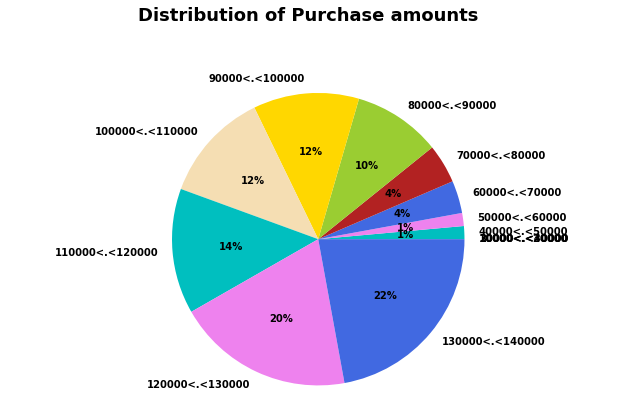

In [77]:
# Purchase count
price_range = [10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000,130000,140000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

# Representation of the number of purchases / amount       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of Purchase amounts", ha='center', fontsize = 18);

It can be seen that the vast majority of orders concern relatively large purchases given that 68% of purchase amount excess of 110000

In [89]:
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['User_ID'], as_index=False)['Purchase'].sum()
basket_price = temp.rename(columns = {'Purchase':'Basket Price'})

basket_price.loc[:] = temp 

# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('User_ID', ascending = True)[:5]

,User_ID,Basket Price
0,1000001,333481
1,1000002,810353
2,1000003,341635
3,1000004,205987
4,1000005,821001


The above table gives us the basket price of each user

In [1]:
import numpy as np
import pandas as ps

from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import linear_model

from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

C:\Users\vigne\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\vigne\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train =ps.read_csv("C:/Vignesh/Studies/Fall 2018/Adv Stats IDS 575/Project/Black Friday/train.csv")

In [4]:
test =ps.read_csv("C:/Vignesh/Studies/Fall 2018/Adv Stats IDS 575/Project/Black Friday/test.csv")

In [4]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [5]:
merged = [train, test]
input = ps.concat(merged)

print (input.shape)
input.head()

(783667, 12)


,Age,City_Category,Gender,Marital_Status,Occupation,Product_Category_1,Product_Category_2,Product_Category_3,Product_ID,Purchase,Stay_In_Current_City_Years,User_ID
0,0-17,A,F,0,10,3,NaN,NaN,P00069042,8370.0,2,1000001
1,0-17,A,F,0,10,1,6.0,14.0,P00248942,15200.0,2,1000001
2,0-17,A,F,0,10,12,NaN,NaN,P00087842,1422.0,2,1000001
3,0-17,A,F,0,10,12,14.0,NaN,P00085442,1057.0,2,1000001
4,55+,C,M,0,16,8,NaN,NaN,P00285442,7969.0,4+,1000002


In [8]:
input.dtypes

Age                            object
City_Category                  object
Gender                         object
Marital_Status                  int64
Occupation                      int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Product_ID                     object
Purchase                      float64
Stay_In_Current_City_Years     object
User_ID                         int64
dtype: object

In [6]:
input.fillna(999, inplace=True)

In [7]:
#Creating target col
target = input.Purchase

In [8]:
target = np.array(target)

In [9]:
#Droping purchase col from input
input.drop(["Purchase"], axis=1, inplace=True)

In [13]:
print (input.columns, input.dtypes)

Index(['Age', 'City_Category', 'Gender', 'Marital_Status', 'Occupation',
       'Product_Category_1', 'Product_Category_2', 'Product_Category_3',
       'Product_ID', 'Stay_In_Current_City_Years', 'User_ID'],
      dtype='object') Age                            object
City_Category                  object
Gender                         object
Marital_Status                  int64
Occupation                      int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Product_ID                     object
Stay_In_Current_City_Years     object
User_ID                         int64
dtype: object


In [10]:
#Converting all the columns to string 
input = input.applymap(str)
input.dtypes

Age                           object
City_Category                 object
Gender                        object
Marital_Status                object
Occupation                    object
Product_Category_1            object
Product_Category_2            object
Product_Category_3            object
Product_ID                    object
Stay_In_Current_City_Years    object
User_ID                       object
dtype: object

In [12]:
#making a copy
# Have a copy of the pandas dataframe. Will be useful later on
input_df = input.copy()

In [13]:
#Convert factors to numeric using LabelEncoder

input = np.array(input)

for a in range(input.shape[1]):
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(input[:,a]))
    input[:, a] = lbl.transform(input[:, a])

In [14]:
input = input.astype(int)

### Model Creation

#### Splitting data into two sections to create meta features in one and feed it to the other model

In [15]:
sec_1_rows = np.random.randint(train.shape[0], size = np.int(train.shape[0]/2))

In [16]:
train_np   = input[:train.shape[0], :]
target_np  = target[:train.shape[0]]
train_first   = train_np[sec_1_rows, :]
target_first  = target_np[sec_1_rows]
train_second   = train_np[-sec_1_rows, :]
target_second  = target_np[-sec_1_rows]

In [17]:
print (train_first.shape, target_first.shape, train_second.shape, target_second.shape)

(275034, 11) (275034,) (275034, 11) (275034,)


In [23]:
train_first

array([[   2,    0,    0, ..., 1896,    1,  487],
       [   5,    0,    1, ..., 3076,    1, 1808],
       [   1,    1,    1, ..., 1627,    2, 3734],
       ...,
       [   1,    1,    1, ..., 1744,    1, 4694],
       [   5,    2,    1, ..., 1405,    4, 3151],
       [   2,    1,    1, ..., 3117,    3, 2043]])

In [24]:
train_second

array([[   5,    1,    1, ..., 3613,    3, 1603],
       [   4,    1,    1, ..., 3164,    1, 4667],
       [   3,    2,    1, ..., 1017,    4, 2854],
       ...,
       [   5,    1,    0, ...,  882,    1, 1830],
       [   2,    1,    1, ..., 2658,    3, 3528],
       [   2,    1,    1, ..., 1064,    2, 4412]])

In [18]:
xgmattrain = xgb.DMatrix(train_first, label=target_first)
collection = [(xgmattrain, 'train')]

# Model 1: maxdepth 6/ rounds 3000

params = {}
params["min_child_weight"] = 10
params["subsample"] = 0.7
params["colsample_bytree"] = 0.7
params["scale_pos_weight"] = 0.8
params["silent"] = 1
params["max_depth"] = 6
params["nthread"] = 6
#params["gamma"] = 1
params["objective"] = "reg:linear"
params["eta"] = 0.1
params["base_score"] = 1800
params["eval_metric"] = "rmse"
params["seed"] = 0

par_list = list(params.items())
no_of_rounds = 3000

model_1 = xgb.train(par_list, xgmattrain, no_of_rounds)

In [19]:
# Model 2: maxdepth 8/ rounds 1420

params = {}
params["min_child_weight"] = 10
params["subsample"] = 0.7
params["colsample_bytree"] = 0.7
params["scale_pos_weight"] = 0.8
params["silent"] = 1
params["max_depth"] = 8
params["nthread"] = 6
#params["gamma"] = 1
params["objective"] = "reg:linear"
params["eta"] = 0.1
params["base_score"] = 1800
params["eval_metric"] = "rmse"
params["seed"] = 0

par_list = list(params.items())
no_of_rounds = 1420

model_2 = xgb.train(par_list, xgmattrain, no_of_rounds)

In [20]:
# Model 3: maxdepth 10/ rounds 1200

params = {}
params["min_child_weight"] = 10
params["subsample"] = 0.7
params["colsample_bytree"] = 0.7
params["scale_pos_weight"] = 0.8
params["silent"] = 1
params["max_depth"] = 10
params["nthread"] = 6
#params["gamma"] = 1
params["objective"] = "reg:linear"
params["eta"] = 0.1
params["base_score"] = 1800
params["eval_metric"] = "rmse"
params["seed"] = 0

par_list = list(params.items())
no_of_rounds = 1200

model_3 = xgb.train(par_list, xgmattrain, no_of_rounds)

In [21]:
# Model 4: maxdepth 12/ rounds 800

params = {}
params["min_child_weight"] = 10
params["subsample"] = 0.7
params["colsample_bytree"] = 0.7
params["scale_pos_weight"] = 0.8
params["silent"] = 1
params["max_depth"] = 12
params["nthread"] = 6
#params["gamma"] = 1
params["objective"] = "reg:linear"
params["eta"] = 0.1
params["base_score"] = 1800
params["eval_metric"] = "rmse"
params["seed"] = 0

par_list = list(params.items())
no_of_rounds = 800

model_4 = xgb.train(par_list, xgmattrain, no_of_rounds)

In [22]:
# These models are ExtraTrees

# Model 5: maxdepth 8/ rounds 1450

model_5 = ExtraTreesRegressor(n_estimators=1450, 
                              max_depth=8,
                              min_samples_split=10, 
                              min_samples_leaf=10, 
                              oob_score=True, 
                              n_jobs=6, 
                              random_state=123, 
                              verbose=1, 
                              bootstrap=True)
model_5.fit(train_first, target_first)

# Model 6: maxdepth 6/rounds 3000

model_6 = ExtraTreesRegressor(n_estimators=3000, 
                              max_depth=6,
                              min_samples_split=10, 
                              min_samples_leaf=10, 
                              oob_score=True, 
                              n_jobs=6, 
                              random_state=123, 
                              verbose=1, 
                              bootstrap=True)
model_6.fit(train_first, target_first)

# Model 7: maxdepth 12/rounds 800

model_7 = ExtraTreesRegressor(n_estimators=800, 
                              max_depth=12,
                              min_samples_split=10, 
                              min_samples_leaf=10, 
                              oob_score=True, 
                              n_jobs=6, 
                              random_state=123, 
                              verbose=1, 
                              bootstrap=True)
model_7.fit(train_first, target_first)

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.2s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   18.3s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   42.4s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 1450 out of 1450 | elapsed:  2.4min finished
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   16.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   36.6s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 3000 out of 3000 | elapsed:  4.1min finished
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.2s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   27.4

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=12,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=10, min_samples_split=10,
          min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=6,
          oob_score=True, random_state=123, verbose=1, warm_start=False)

In [23]:
#RandomForest Models

# Model 8: jobs 6 /estimators 3000
model_8 = RandomForestRegressor(n_estimators=3000, max_depth=6, oob_score=True, n_jobs=6, random_state=123, min_samples_split=10, min_samples_leaf=10)
model_8.fit(train_first, target_first)

# Model 9: jobs 8/estimators 1500
model_9 = RandomForestRegressor(n_estimators=1500, max_depth=8, oob_score=True, n_jobs=6, random_state=123, min_samples_split=10, min_samples_leaf=10)
model_9.fit(train_first, target_first)

# Model 10: 12/800
model_10 = RandomForestRegressor(n_estimators=800, max_depth=12, oob_score=True, n_jobs=6, random_state=123, min_samples_split=10, min_samples_leaf=10)
model_10.fit(train_first, target_first)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=6,
           oob_score=True, random_state=123, verbose=0, warm_start=False)

In [24]:
model_1_predict = model_1.predict(xgb.DMatrix(train_second))
model_2_predict = model_2.predict(xgb.DMatrix(train_second))
model_3_predict = model_3.predict(xgb.DMatrix(train_second))
model_4_predict = model_4.predict(xgb.DMatrix(train_second))
model_5_predict = model_5.predict(train_second)
model_6_predict = model_6.predict(train_second)
model_7_predict = model_7.predict(train_second)
model_8_predict = model_8.predict(train_second)
model_9_predict = model_9.predict(train_second)
model_10_predict = model_10.predict(train_second)

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    3.2s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:    5.4s
[Parallel(n_jobs=6)]: Done 1450 out of 1450 | elapsed:    6.4s finished
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    2.6s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:    4.2s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:    6.1s
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:    8.4s
[Parallel(n_jobs=6)]: Done 3000 out of 3000 | elapsed:   10.4s finished
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    1.4

In [29]:
train_second_w_meta = np.concatenate((train_second, np.vstack((model_1_predict, model_2_predict, model_3_predict, 
                                                       model_4_predict, model_5_predict,
              model_6_predict, model_7_predict, model_8_predict, model_9_predict, model_10_predict)).T), axis=1)

In [ ]:
#Second Stage model

In [30]:
kfolds = KFold(train_second_w_meta.shape[0], n_folds=5)

In [31]:
params = {}
params["min_child_weight"] = 10
params["subsample"] = 0.7
params["colsample_bytree"] = 0.7
params["scale_pos_weight"] = 0.8
params["silent"] = 1
params["max_depth"] = 8
params["nthread"] = 6
#params["gamma"] = 1
params["objective"] = "reg:linear"
params["eta"] = 0.1
params["base_score"] = 1800
params["eval_metric"] = "rmse"
params["seed"] = 0

par_list = list(params.items())
no_of_rounds = 1400

In [33]:
for train_index, validation_index in kfolds:
    
    train_X, validation_X = train_second_w_meta[train_index, :], train_second_w_meta[validation_index, :]
    train_y, validation_y = target_second[train_index], target_second[validation_index]
    
    xgmattrain = xgb.DMatrix(train_X, label=train_y)
    collection = [(xgmattrain, 'train')]
    model_cv_xgboost = xgb.train(par_list, xgmattrain, no_of_rounds)
    model_cv_predict = model_cv_xgboost.predict(xgb.DMatrix(validation_X))
    print (np.sqrt(mean_squared_error(validation_y, model_cv_predict)))

2056.606321776378
2059.1392871068774
2049.5403624306623
2053.066033161378
2045.8442597683024


In [ ]:
# RMSE is around 2050.

In [ ]:
# Training second stage model on all the second stage data now

In [34]:
xgtrain = xgb.DMatrix(train_second_w_meta, label=target_second)
collection = [(xgtrain, 'train')]
model_second_xgboost = xgb.train(par_list, xgmattrain, no_of_rounds)

### Final Prediction in Test dataset

In [35]:
model_1_predict = model_1.predict(xgb.DMatrix(input[train.shape[0]:, :]))
model_2_predict = model_2.predict(xgb.DMatrix(input[train.shape[0]:, :]))
model_3_predict = model_3.predict(xgb.DMatrix(input[train.shape[0]:, :]))
model_4_predict = model_4.predict(xgb.DMatrix(input[train.shape[0]:, :]))
model_5_predict = model_5.predict(input[train.shape[0]:, :])
model_6_predict = model_6.predict(input[train.shape[0]:, :])
model_7_predict = model_7.predict(input[train.shape[0]:, :])
model_8_predict = model_8.predict(input[train.shape[0]:, :])
model_9_predict = model_9.predict(input[train.shape[0]:, :])
model_10_predict = model_10.predict(input[train.shape[0]:, :])

test_second_w_meta = np.concatenate((input[train.shape[0]:, :], np.vstack((model_1_predict, model_2_predict, model_3_predict, 
                                                       model_4_predict, model_5_predict,
              model_6_predict, model_7_predict, model_8_predict, model_9_predict, model_10_predict)).T), axis=1)

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    3.6s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    5.9s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:   10.0s
[Parallel(n_jobs=6)]: Done 1450 out of 1450 | elapsed:   11.6s finished
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:    6.1s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:    9.0s
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:   11.5s
[Parallel(n_jobs=6)]: Done 3000 out of 3000 | elapsed:   13.5s finished
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    1.4

In [36]:
model_second_predict = model_second_xgboost.predict(xgb.DMatrix(test_second_w_meta))